<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/Hawaii_Soils_Process_and_Intersect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
install.packages('sf')
install.packages('raster')
install.packages('exactextractr')
install.packages("googledrive")
install.packages("googletoken")
install.packages("DBI")
install.packages("RSQLite")
install.packages("RPostgreSQL")
install.packages("terra")
install.packages('randomForest')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘proxy’, ‘e1071’, ‘wk’, ‘classInt’, ‘s2’, ‘units’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sp’, ‘terra’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘googletoken’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the depende

In [4]:
library(ggplot2)
library(sf)
library(magrittr)
library(data.table)
library(raster)
library(exactextractr)
library(googledrive)
library(DBI) # database
library(terra)
library(randomForest)
library(parallel)

Linking to GEOS 3.11.1, GDAL 3.6.4, PROJ 9.1.1; sf_use_s2() is TRUE

Loading required package: sp

terra 1.7.78


Attaching package: ‘terra’


The following object is masked from ‘package:data.table’:

    shift


The following objects are masked from ‘package:magrittr’:

    extract, inset


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin




In [5]:
drive_auth(use_oob = TRUE, cache = FALSE)

Please point your browser to the following url: 

https://accounts.google.com/o/oauth2/v2/auth?client_id=603366585132-frjlouoa3s2ono25d2l9ukvhlsrlnr7k.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&redirect_uri=https%3A%2F%2Fwww.tidyverse.org%2Fgoogle-callback%2F&response_type=code&state=4b0bb64516500a4f6cb0af693caa22bf&access_type=offline&prompt=consent



Enter authorization code: eyJjb2RlIjoiNC8wQVFsRWQ4eV8yMXFRMC1nN2MxWXNmUHZCVXhlRXlsSzNObkZkU0NyRjQ3QlZBMTNVczBjNHhPS3ZoOE9GR205aU05Z0RjUSIsInN0YXRlIjoiNGIwYmI2NDUxNjUwMGE0ZjZjYjBhZjY5M2NhYTIyYmYifQ==


In [6]:
dir.create('/content/predictor_variables/')

In [7]:
# Hawaii GEDI data
# https://drive.google.com/file/d/1UY3lxML0Y7bat_9-xEZQQHDkYRcODDZy/view?usp=drive_link
drive_download(file = as_id('1UY3lxML0Y7bat_9-xEZQQHDkYRcODDZy'), path =  '/content/predictor_variables/Hawaii_GEDI_4A.gpkg', overwrite = FALSE)
gedi_sf <- st_read('/content/predictor_variables/Hawaii_GEDI_4A.gpkg')

File downloaded:

• Hawaii_GEDI.gpkg <id: 1UY3lxML0Y7bat_9-xEZQQHDkYRcODDZy>

Saved locally as:

• /content/predictor_variables/Hawaii_GEDI_4A.gpkg



Reading layer `Hawaii_GEDI_2' from data source 
  `/content/predictor_variables/Hawaii_GEDI_4A.gpkg' using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 4839466 features and 28 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -160.6006 ymin: 18.86556 xmax: -154.7559 ymax: 22.28996
Geodetic CRS:  WGS 84


In [8]:
# All islands 250m grid
# https://drive.google.com/file/d/1DcBOzWHwqJovd9hhIqLUjRlc2kpqEGKz/view?usp=drive_link
drive_download(file = as_id('1DcBOzWHwqJovd9hhIqLUjRlc2kpqEGKz'), path =  '/content/predictor_variables/HI_250_m_grid.gpkg', overwrite = FALSE)

File downloaded:

• 250_summary_grid_dt_USE_THIS.gpkg <id: 1DcBOzWHwqJovd9hhIqLUjRlc2kpqEGKz>

Saved locally as:

• /content/predictor_variables/HI_250_m_grid.gpkg



In [9]:
folder_loc <- '/content/predictor_variables/TerraClimate/'
dir.create(folder_loc)

# https://drive.google.com/drive/folders/1bIbwKYmzP2o6VEAWyLIRmeMQbGFDt-vX?usp=drive_link
folder_id <- "1bIbwKYmzP2o6VEAWyLIRmeMQbGFDt-vX"
folder_files <- drive_ls(as_id(folder_id))

for (i in 1:nrow(folder_files)) {
  file_id <- folder_files$id[i]
  file_name <- folder_files$name[i]
  drive_download(as_id(file_id), path = paste0(folder_loc,file_name), overwrite = TRUE)
}


File downloaded:

• Oahu_Mean_Climate_1958_to_2023.tif <id: 1zNyLGypMkzHYLoMnOTHhpZmZbil88Xxe>

Saved locally as:

• /content/predictor_variables/TerraClimate/Oahu_Mean_Climate_1958_to_2023.tif

File downloaded:

• Kauai_Mean_Climate_1958_to_2023.tif <id: 14bpiZID-VOQmsEVeQc9gFHe8JYK7w_ew>

Saved locally as:

• /content/predictor_variables/TerraClimate/Kauai_Mean_Climate_1958_to_2023.tif

File downloaded:

• Niihau_Mean_Climate_1958_to_2023.tif <id: 1T9RfMhwprSe0YV_ln5Xky9QTYycuh6M3>

Saved locally as:

• /content/predictor_variables/TerraClimate/Niihau_Mean_Climate_1958_to_2023.tif

File downloaded:

• Hawaii_Mean_Climate_1958_to_2023.tif <id: 1pMs5OsTwQ1N3kXO9bb3W-qfhxwcJtzIj>

Saved locally as:

• /content/predictor_variables/TerraClimate/Hawaii_Mean_Climate_1958_to_2023.tif

File downloaded:

• Lanai_Mean_Climate_1958_to_2023.tif <id: 1eFkEW2ZRWtMK-IMEpVJ28R3xups_HhOT>

Saved locally as:

• /content/predictor_variables/TerraClimate/Lanai_Mean_Climate_1958_to_2023.tif

File download

replace files in the Drive folder

In [10]:
folder_loc <- '/content/predictor_variables/SRTM_mTPI/'
dir.create(folder_loc)

# https://drive.google.com/drive/folders/1YKJrZXTo-L4UpvJ0iEGo8yIX6uhoQ9AW?usp=drive_link
folder_id <- "1YKJrZXTo-L4UpvJ0iEGo8yIX6uhoQ9AW"
folder_files <- drive_ls(as_id(folder_id))

for (i in 1:nrow(folder_files)) {
  file_id <- folder_files$id[i]
  file_name <- folder_files$name[i]
  drive_download(as_id(file_id), path = paste0(folder_loc,file_name), overwrite = TRUE)
}

File downloaded:

• Metadata <id: 1GB4d-4-xOOFHbf6R8z8yw5ZVYe4n-Oz-lSM43dpESb0>

Saved locally as:

• /content/predictor_variables/SRTM_mTPI/Metadata.docx

File downloaded:

• Oahu_SRTM_mTPI_Buffer.tif <id: 1MJEjAuHBeDmvfU_7W4j6RZJk6uLD4TE_>

Saved locally as:

• /content/predictor_variables/SRTM_mTPI/Oahu_SRTM_mTPI_Buffer.tif

File downloaded:

• Niihau_SRTM_mTPI_Buffer.tif <id: 1JlGaWub7TJ31v7V1GSDQRIq5Mw4wcZx0>

Saved locally as:

• /content/predictor_variables/SRTM_mTPI/Niihau_SRTM_mTPI_Buffer.tif

File downloaded:

• Maui_SRTM_mTPI_Buffer.tif <id: 1MsRCpuNGuIKInYotrbJ5S-Sagion0wJo>

Saved locally as:

• /content/predictor_variables/SRTM_mTPI/Maui_SRTM_mTPI_Buffer.tif

File downloaded:

• Molakai_SRTM_mTPI_Buffer.tif <id: 1WRDZse9NGahMQ4h22bxvsv4XFp10JJZW>

Saved locally as:

• /content/predictor_variables/SRTM_mTPI/Molakai_SRTM_mTPI_Buffer.tif

File downloaded:

• Lanai_SRTM_mTPI_Buffer.tif <id: 1sz3x9fZufpjbtrIpY3ZovhNknmDmkR5n>

Saved locally as:

• /content/predictor_variables/

In [11]:
folder_loc <- '/content/predictor_variables/Elevation/'
dir.create(folder_loc)

# https://drive.google.com/drive/folders/1XmH9T9xVINZZfPFi39Wus1l7c0SKS4Am?usp=drive_link
folder_id <- "1XmH9T9xVINZZfPFi39Wus1l7c0SKS4Am"
folder_files <- drive_ls(as_id(folder_id))

for (i in 1:nrow(folder_files)) {
  file_id <- folder_files$id[i]
  file_name <- folder_files$name[i]
  drive_download(as_id(file_id), path = paste0(folder_loc,file_name), overwrite = TRUE)
}

File downloaded:

• Oahu_elevation-0000000000-0000046592.tif
  <id: 1yRDrfvLTEGECTDQcwXRIxoHmUu3D9LL4>

Saved locally as:

• /content/predictor_variables/Elevation/Oahu_elevation-0000000000-0000046592.tif

File downloaded:

• Oahu_elevation-0000000000-0000000000.tif
  <id: 1YMV_pXPQjmdam7ucBItWqzFJPPYQK7H5>

Saved locally as:

• /content/predictor_variables/Elevation/Oahu_elevation-0000000000-0000000000.tif

File downloaded:

• Hawaii_elevation.tif <id: 116xUvGPbJvJQrFZ7b59EzmcyAPHgKQmN>

Saved locally as:

• /content/predictor_variables/Elevation/Hawaii_elevation.tif

File downloaded:

• Maui_elevation.tif <id: 1Or-pj4QiOj8VgMOAPtVjMm_ocbrvGM6_>

Saved locally as:

• /content/predictor_variables/Elevation/Maui_elevation.tif

File downloaded:

• Niihau_elevation.tif <id: 1L6lodPtr7u70scb-gu_QliaAIyEwYAtc>

Saved locally as:

• /content/predictor_variables/Elevation/Niihau_elevation.tif

File downloaded:

• Molokai_elevation.tif <id: 1ae2lpPQngdFx58mRpqt02Z1bQg-Tifen>

Saved locally as:

In [12]:
folder_loc <- '/content/predictor_variables/LandForms/'
dir.create(folder_loc)

# https://drive.google.com/drive/folders/1PkUR4GK50wC6Kgrvyy-d6067ypdX1dkx?usp=drive_link
folder_id <- "1PkUR4GK50wC6Kgrvyy-d6067ypdX1dkx"
folder_files <- drive_ls(as_id(folder_id))

for (i in 1:nrow(folder_files)) {
  file_id <- folder_files$id[i]
  file_name <- folder_files$name[i]
  drive_download(as_id(file_id), path = paste0(folder_loc,file_name), overwrite = TRUE)
}

File downloaded:

• Oahu_Landforms_Buffer-0000000000-0000065536.tif
  <id: 1PcZoQe0l8WLgSagiWWUpTmWmmHmGnIRx>

Saved locally as:

• /content/predictor_variables/LandForms/Oahu_Landforms_Buffer-0000000000-0000065536.tif

File downloaded:

• Oahu_Landforms_Buffer-0000000000-0000000000.tif
  <id: 1AzX2SjqLBZnxIfRwNAjzXQQuQGujN24p>

Saved locally as:

• /content/predictor_variables/LandForms/Oahu_Landforms_Buffer-0000000000-0000000000.tif

File downloaded:

• Hawaii_Landforms_Buffer.tif <id: 1qBNjiXKd-JJ8CICZvVTo42kkKjBNhYMT>

Saved locally as:

• /content/predictor_variables/LandForms/Hawaii_Landforms_Buffer.tif

File downloaded:

• Niihau_Landforms_Buffer.tif <id: 16jkuVWQ_BIjLBJiTeZeHMj3Z_FCJ4ttm>

Saved locally as:

• /content/predictor_variables/LandForms/Niihau_Landforms_Buffer.tif

File downloaded:

• Maui_Landforms_Buffer.tif <id: 1v1bBZWsHDYWZfhfGby_wWylkSrVQaqx9>

Saved locally as:

• /content/predictor_variables/LandForms/Maui_Landforms_Buffer.tif

File downloaded:

• Molakai_La

In [13]:
folder_loc <- '/content/predictor_variables/LandSat_composite/'
dir.create(folder_loc)

# https://drive.google.com/drive/folders/1NzvurSghdEJdX0UsfdyuOcOyh6n3jUDo?usp=drive_link
folder_id <- "1NzvurSghdEJdX0UsfdyuOcOyh6n3jUDo"
folder_files <- drive_ls(as_id(folder_id))

for (i in 1:nrow(folder_files)) {
  file_id <- folder_files$id[i]
  file_name <- folder_files$name[i]
  drive_download(as_id(file_id), path = paste0(folder_loc,file_name), overwrite = TRUE)
}

File downloaded:

• Oahu_LS_composite_2012_2018-0000026880-0000071680.tif
  <id: 1EYTgSBFIkoImi8KSh3k3dA7Q-RKgvViS>

Saved locally as:

• /content/predictor_variables/LandSat_composite/Oahu_LS_composite_2012_2018-0000026880-0000071680.tif

File downloaded:

• Oahu_LS_composite_2012_2018-0000026880-0000062720.tif
  <id: 198oPEMLWxG_yw81FiQZPX_QYynTnTCNU>

Saved locally as:

• /content/predictor_variables/LandSat_composite/Oahu_LS_composite_2012_2018-0000026880-0000062720.tif

File downloaded:

• Oahu_LS_composite_2012_2018-0000026880-0000053760.tif
  <id: 1GYZbsuuHnIppFck45JbPTeuL1yjpZurC>

Saved locally as:

• /content/predictor_variables/LandSat_composite/Oahu_LS_composite_2012_2018-0000026880-0000053760.tif

File downloaded:

• Oahu_LS_composite_2012_2018-0000026880-0000044800.tif
  <id: 15wOx4LbskGPYH2MBokQ2g210Z69OR10V>

Saved locally as:

• /content/predictor_variables/LandSat_composite/Oahu_LS_composite_2012_2018-0000026880-0000044800.tif

File downloaded:

• Oahu_LS_composite_20

In [14]:
folder_loc <- '/content/predictor_variables/DynamicWorld_landcover/'
dir.create(folder_loc)

# https://drive.google.com/drive/folders/152pjTArpwlDVGjXFoSU9bmo1BDSKdCqq?usp=drive_link
folder_id <- "152pjTArpwlDVGjXFoSU9bmo1BDSKdCqq"
folder_files <- drive_ls(as_id(folder_id))

for (i in 1:nrow(folder_files)) {
  file_id <- folder_files$id[i]
  file_name <- folder_files$name[i]
  drive_download(as_id(file_id), path = paste0(folder_loc,file_name), overwrite = TRUE)
}

File downloaded:

• Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000074240-0000230144.tif
  <id: 19FuR7du29_3ardEMZpUvOAr0ogyeUdo->

Saved locally as:

• /content/predictor_variables/DynamicWorld_landcover/Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000074240-0000230144.tif

File downloaded:

• Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000074240-0000222720.tif
  <id: 1KLCjkT__5mZRpDNe3BZgJq-1apVKzh40>

Saved locally as:

• /content/predictor_variables/DynamicWorld_landcover/Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000074240-0000222720.tif

File downloaded:

• Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000074240-0000215296.tif
  <id: 1RsExGzHzQv2R_SiPVOGhelM4dIe19L-n>

Saved locally as:

• /content/predictor_variables/DynamicWorld_landcover/Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000074240-0000215296.tif

File downloaded:

• Oahu_Average_Land_Cover_Buffer_2000m_2015_to_2019-0000074240-0000207872.tif
  <id: 1e6HI22pBKkD3ZCAJGAcpdxVEYQwn0

In [15]:
  # https://drive.google.com/file/d/1ryTzWz0t9mgI5ynPvMzM21D135dLJvWv/view?usp=drive_link
  # Updated: https://drive.google.com/file/d/17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C/view?usp=sharing
# drive_download(as_id('17c3DJcujQ_0MHirG2z2lSU88A0lvjo1C'), path = paste0('/content/fia.csv'), overwrite = TRUE)
# fia_dt <-  st_read('/content/fia.csv') %>% st_as_sf(coords = c("LON","LAT"), crs = 4326) %>% data.table

In [16]:
dir_list <- list.dirs('/content/predictor_variables')[-1]

names(dir_list) <- list.dirs('/content/predictor_variables',full.names = FALSE)[-1]

vrt is making a virtual raster tile
option to fix the issue: make a vrt individually for each island then stack them after
see if terraclimate is the issue (for Kauai), getting hidden by Oahu data

In [17]:
# List of your TIFF files
tif_files <- list.files("/content/predictor_variables/TerraClimate", pattern = "\\.tif$", full.names = TRUE)

# Read the TIFF files into a list of raster objects
raster_list <- lapply(tif_files, rast)

mosaic_raster <- do.call(mosaic, c(raster_list, fun = max))

writeRaster(mosaic_raster, "/content/predictor_variables/TerraClimate.tif", overwrite = TRUE)

In [145]:
# List of your TIFF files
tif_files <- list.files("/content/predictor_variables/SRTM_mTPI", pattern = "\\.tif$", full.names = TRUE)

# Read the TIFF files into a list of raster objects
raster_list <- lapply(tif_files, rast)

mosaic_raster <- do.call(mosaic, c(raster_list, fun = max))

writeRaster(mosaic_raster, "/content/predictor_variables/SRTM_mTPI.tif", overwrite = TRUE)

In [146]:
# List of your TIFF files
tif_files <- list.files("/content/predictor_variables/LandForms", pattern = "\\.tif$", full.names = TRUE)

# Read the TIFF files into a list of raster objects
raster_list <- lapply(tif_files, rast)

mosaic_raster <- do.call(mosaic, c(raster_list, fun = max))

writeRaster(mosaic_raster, "/content/predictor_variables/LandForms.tif", overwrite = TRUE)

In [18]:
names(dir_list) %>% lapply(function(x){
# print(x)
 y <- dir_list[[x]]
 vrt(y %>% lapply(function(x){
  file_list <- list.files(y, pattern='*.tif',full.names = T)
  file_sizes <- lapply(file_list,file.size) %>% unlist %>% order
  file_list[file_sizes] %>% return
  }) %>% unlist,filename=paste0(y,'/',x,'.vrt'),overwrite=T)
#  vrt_rast <- paste0(y,'/',x,'.vrt') %>% rast
#  writeRaster(vrt_rast, paste0('/content/predictor_mosaic/',x,'.tif'),overwrite=T)
#  print(paste('Done',x))
})

[[1]]
class       : SpatRaster 
dimensions  : 371833, 2204931, 10  (nrow, ncol, nlyr)
resolution  : 9.031842e-05, 9.031842e-05  (x, y)
extent      : -178.4436, 20.70229, 18.8654, 52.44877  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : DynamicWorld_landcover.vrt 
names       : Dynam~ver_1, Dynam~ver_2, Dynam~ver_3, Dynam~ver_4, Dynam~ver_5, Dynam~ver_6, ... 

[[2]]
class       : SpatRaster 
dimensions  : 35816, 87898, 1  (nrow, ncol, nlyr)
resolution  : 0.0002694946, 0.0002694946  (x, y)
extent      : -178.4436, -154.7556, 18.8652, 28.51742  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : Elevation.vrt 
name        : Elevation 

[[3]]
class       : SpatRaster 
dimensions  : 80530, 270460, 1  (nrow, ncol, nlyr)
resolution  : 0.0002694946, 0.0002694946  (x, y)
extent      : -178.4437, -105.5562, 18.86543, 40.56783  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : LandForms.vrt 
name        

In [19]:
list.files('/content/predictor_variables',pattern = '*.vrt',full.names = T,recursive = T)

[1] "/content/predictor_variables/DynamicWorld_landcover/DynamicWorld_landcover.vrt"
[2] "/content/predictor_variables/Elevation/Elevation.vrt"                          
[3] "/content/predictor_variables/LandForms/LandForms.vrt"                          
[4] "/content/predictor_variables/LandSat_composite/LandSat_composite.vrt"          
[5] "/content/predictor_variables/SRTM_mTPI/SRTM_mTPI.vrt"                          
[6] "/content/predictor_variables/TerraClimate/TerraClimate.vrt"

In [154]:
raster_list <- list.files('/content/predictor_variables',pattern = '*.vrt',full.names = T,recursive = T) %>% lapply(stack) %>% lapply(rast)

raster_list

[[1]]
class       : SpatRaster 
dimensions  : 371833, 2204931, 10  (nrow, ncol, nlyr)
resolution  : 9.031842e-05, 9.031842e-05  (x, y)
extent      : -178.4436, 20.70229, 18.8654, 52.44877  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs 
source      : DynamicWorld_landcover.vrt 
names       : Dynam~ver_1, Dynam~ver_2, Dynam~ver_3, Dynam~ver_4, Dynam~ver_5, Dynam~ver_6, ... 

[[2]]
class       : SpatRaster 
dimensions  : 35816, 87898, 1  (nrow, ncol, nlyr)
resolution  : 0.0002694946, 0.0002694946  (x, y)
extent      : -178.4436, -154.7556, 18.8652, 28.51742  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs 
source      : Elevation.vrt 
name        : Elevation 

[[3]]
class       : SpatRaster 
dimensions  : 80530, 270460, 1  (nrow, ncol, nlyr)
resolution  : 0.0002694946, 0.0002694946  (x, y)
extent      : -178.4437, -105.5562, 18.86543, 40.56783  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs 
source      : 

In [155]:
raster_list[[3]] <- rast('/content/predictor_variables/LandForms.tif')

In [156]:
raster_list[[5]] <- rast('/content/predictor_variables/SRTM_mTPI.tif')

In [157]:
raster_list[[6]] <- rast('/content/predictor_variables/TerraClimate.tif')

In [22]:
gedi_dt <- st_read('/content/predictor_variables/Hawaii_GEDI_4A.gpkg') %>% data.table()

Reading layer `Hawaii_GEDI_2' from data source 
  `/content/predictor_variables/Hawaii_GEDI_4A.gpkg' using driver `GPKG'
Integer64 values larger than 9.0072e+15 lost significance after conversion to double;
use argument int64_as_string = TRUE to import them lossless, as character
Simple feature collection with 4839466 features and 28 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -160.6006 ymin: 18.86556 xmax: -154.7559 ymax: 22.28996
Geodetic CRS:  WGS 84


In [23]:
#https://drive.google.com/file/d/1DcBOzWHwqJovd9hhIqLUjRlc2kpqEGKz/view?usp=drive_link
grid_dt <- st_read('/content/predictor_variables/HI_250_m_grid.gpkg') %>% data.table()

Reading layer `250_summary_grid_dt' from data source 
  `/content/predictor_variables/HI_250_m_grid.gpkg' using driver `GPKG'
Simple feature collection with 359163 features and 35 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -159.7877 ymin: 18.91217 xmax: -154.807 ymax: 22.23237
Geodetic CRS:  WGS 84


In [151]:
example_poly <- grid_dt[grid_dt$vpd %>% is.na(),] %>% st_as_sf %>% st_transform(4135) %>% st_buffer(250) %>% st_transform(4326)

In [24]:
# example_poly <- grid_dt %>% st_as_sf %>% st_transform(4135) %>% st_buffer(250) %>% st_transform(4326)

In [158]:
raster_list[[1]]

class       : SpatRaster 
dimensions  : 371833, 2204931, 10  (nrow, ncol, nlyr)
resolution  : 9.031842e-05, 9.031842e-05  (x, y)
extent      : -178.4436, 20.70229, 18.8654, 52.44877  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=longlat +datum=WGS84 +no_defs 
source      : DynamicWorld_landcover.vrt 
names       : Dynam~ver_1, Dynam~ver_2, Dynam~ver_3, Dynam~ver_4, Dynam~ver_5, Dynam~ver_6, ... 

In [159]:
  cover_dt <- data.table(exact_extract(raster_list[[1]],example_poly %>% st_as_sf,'mean',progress = TRUE) %>% data.table)
  names(cover_dt) <- c("water", "trees", "grass", "flooded_vegetation", "crops", "shrub_and_scrub", "built", "bare", "snow_and_ice",'max')

  elevation_dt <- data.table(exact_extract(raster_list[[2]],example_poly %>% st_as_sf,'mean',progress = TRUE) %>% data.table)
  names(elevation_dt) <- c("elevation")

  landform_dt <- data.table(exact_extract(raster_list[[3]],example_poly %>% st_as_sf,'mode',progress = TRUE) %>% data.table)
  names(landform_dt) <- c("landform")

  ls_dt <- data.table(exact_extract(raster_list[[4]],example_poly %>% st_as_sf,'mean',progress = TRUE) %>% data.table)
  names(ls_dt) <- c("ultra_blue", "blue", "green", "red", "infrared", "sw1", "sw2")

  tpi_dt <- data.table(exact_extract(raster_list[[5]],example_poly %>% st_as_sf,'mean',progress = TRUE) %>% data.table)
  names(tpi_dt) <- c("SRTM_mTPI")

  climate_dt <- data.table(exact_extract(raster_list[[6]],example_poly %>% st_as_sf,'mean',progress = TRUE) %>% data.table)
  names(climate_dt) <- c("aet", "def", "pdsi", "pet", "pr", "ro", "soil", "srad", "swe", "tmmn", "tmmx", "vap", "vpd", "vs")


Cannot preload entire working area of 15722100520 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 176597712 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 176597712 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 1236183984 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [98]:
# gedi_sf$l4_quality_flag %>% table
# gedi_dt <-gedi_sf %>% data.table
gedi_dt <- gedi_dt[l4_quality_flag == 1]

In [99]:
gedi_dt_coords<- gedi_dt$geom %>% st_coordinates

In [100]:
gedi_summary_dt <- 1:nrow(example_poly) %>% lapply(function(x){

  example_bbox <- st_bbox(example_poly[x,])

  coords_in_bbox <- gedi_dt_coords[, "X"] >= example_bbox["xmin"] &
                    gedi_dt_coords[, "X"] <= example_bbox["xmax"] &
                    gedi_dt_coords[, "Y"] >= example_bbox["ymin"] &
                    gedi_dt_coords[, "Y"] <= example_bbox["ymax"]

  coords_in_bbox <- coords_in_bbox %>% which

  sub_gedi_dt <- gedi_dt[example_poly[x,]$geom %>% st_intersects(.,gedi_dt[coords_in_bbox,]$geom) %>% unlist,]

  sub_gedi_dt[,list(agbd_m = mean(agbd,na.rm=T),agbd_sd = sd(agbd,na.rm=T),agbd_n = length(agbd))]
}) %>% rbindlist()

In [ ]:
# gedi_summary_dt <- gedi_int_dt %>% lapply(function(x){
#   sub_gedi_dt <- gedi_dt[x,]
#   sub_gedi_dt[,list(agbd_m = mean(agbd,na.rm=T),agbd_sd = sd(agbd,na.rm=T),agbd_n = length(agbd))]
# }) %>% rbindlist()

In [160]:
# gedi_summary_dt %>% nrow
hold_example_poly <- example_poly

In [161]:
example_poly$geom <- grid_dt[grid_dt$vpd %>% is.na(),]$geom

In [162]:
rf_dt <- data.table(example_poly[,c(1,2,3,4,5,ncol(example_poly))],cover_dt,elevation_dt,landform_dt,tpi_dt,climate_dt,gedi_summary_dt)


In [163]:
rf_dt %>% nrow

[1] 33171

In [164]:
grid_dt[!(grid_dt$vpd %>% is.na()),] %>% nrow

[1] 325992

In [166]:
# rf_dt %>% lapply(function(x){is.na(x) %>% table})

In [129]:
# grid_dt  %>% nrow

[1] 359163

In [131]:
# rf_dt[,names(grid_dt),with=F] %>% lapply(class)

In [ ]:
# rf_dt[,names(grid_dt)]

In [167]:
rf_dt <- rbindlist(list(grid_dt[!(grid_dt$vpd %>% is.na()),],rf_dt[,names(grid_dt),with=F]),use.names = T)

In [92]:
# qplot(rf_dt$agbd_m,grid_dt[grid_sample,]$agbd_m)

In [ ]:
# grid_dt[grid_sample,]$vpd

In [ ]:
# rf_dt$geom <- grid_dt[grid_int_unique]$geom


In [ ]:
# rf_dt %>% st_as_sf %>% st_write('250_summary_grid_dt.gpkg',delete_dsn = T)

In [168]:
rf_dt$vpd %>% is.na %>% table

.
 FALSE   TRUE 
359112     51 

Warning message:
“Removed 98320 rows containing non-finite outside the scale range
(`stat_bin2d()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 98320 rows containing non-finite outside the scale range
(`stat_smooth()`).”


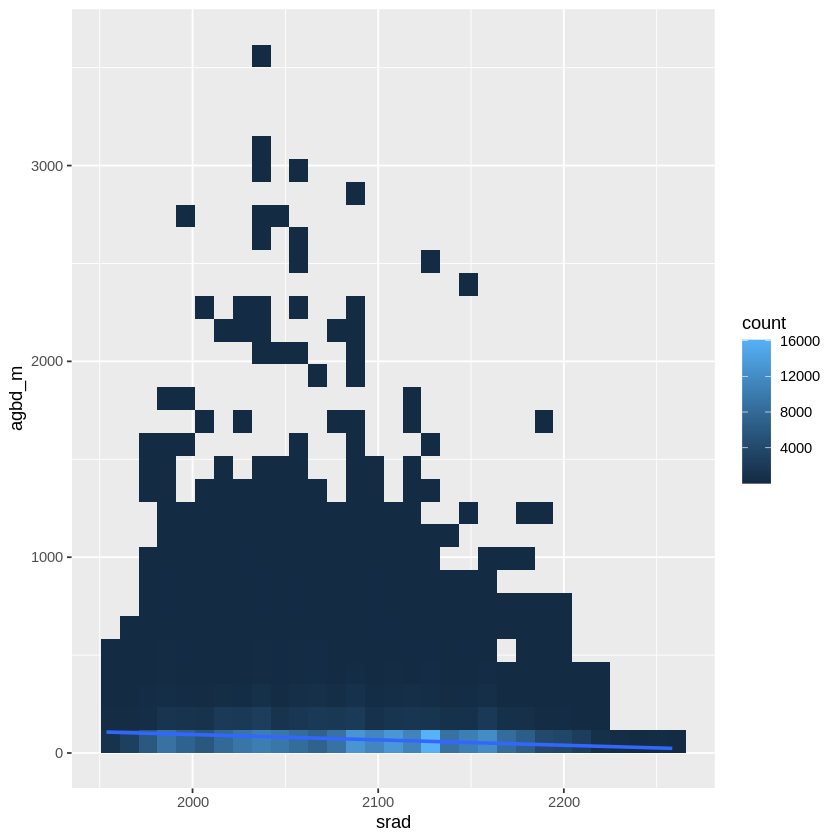

In [169]:
rf_dt %>%
  ggplot(aes(x=srad,y=agbd_m)) +
  # xlim(0,500)+

  geom_bin2d() +
    geom_smooth(method='lm')

In [170]:
rf_dt %>% st_write("/content/250_summary_grid_dt.gpkg",delete_dsn = T)

Deleting source `/content/250_summary_grid_dt.gpkg' using driver `GPKG'
Writing layer `250_summary_grid_dt' to data source 
  `/content/250_summary_grid_dt.gpkg' using driver `GPKG'
Writing 359163 features with 35 fields and geometry type Point.


In [171]:
# https://drive.google.com/drive/folders/1uVZCzCb5gRE8wfZckspRuKz1TQd5LpeM?usp=drive_link
drive_upload("/content/250_summary_grid_dt.gpkg", path = as_id("1uVZCzCb5gRE8wfZckspRuKz1TQd5LpeM"))

Auto-refreshing stale OAuth token.

Local file:

• /content/250_summary_grid_dt.gpkg

Uploaded into Drive file:

• 250_summary_grid_dt.gpkg <id: 1P1ASvB8Nbkdug_bcDGBulvSVIWy9pM_0>

With MIME type:

• application/geopackage+sqlite3

